# Kaggle : Predict Future Sales 커널 필사 리뷰

***
모델링


## 패키지 설치

In [ ]:
!pip install catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 제공하는 데이터 셋 모두 불러오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

X_train = pd.read_csv('/content/drive/MyDrive/X_train')
X_validation = pd.read_csv('/content/drive/MyDrive/X_validation')
X_test = pd.read_csv('/content/drive/MyDrive/X_test')
Y_train = pd.read_csv('/content/drive/MyDrive/Y_train')
Y_validation = pd.read_csv('/content/drive/MyDrive/Y_validation')
Y_test = pd.read_csv('/content/drive/MyDrive/Y_test')

## Tree Based model

> # catboost

In [ ]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=[],
    eval_set=(X_validation, Y_validation)
)

In [8]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


## feature importance

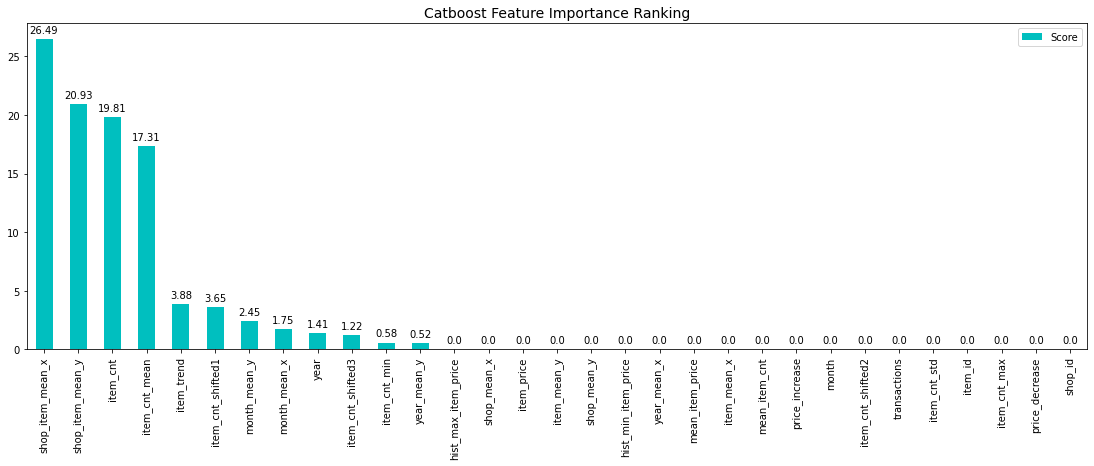

In [54]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=[])))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

- shop_item_mean : 가게 & 제품 별 하루 판매량의 평균

In [6]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [57]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Train rmse: 0.6715631146028993
Validation rmse: 0.8090170489522475


> # XGBoost

In [7]:
xgb_features = ['item_cnt','item_cnt_mean','item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean_x','shop_mean_y', 
                'shop_item_mean_x','shop_item_mean_y', 'item_trend', 'mean_item_cnt']
              
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [ ]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[08:45:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:45:33] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.937924	validation_1-rmse:0.929275
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.


### XGBoost feature importance


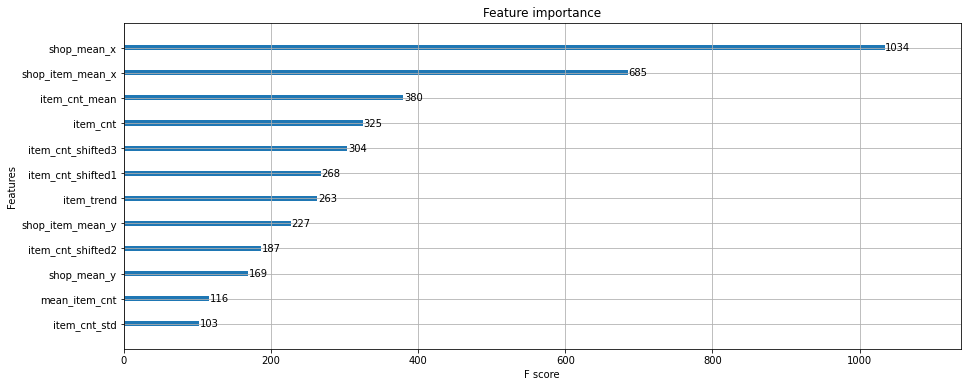

In [11]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [12]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [13]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train rmse: 0.6919738510742263
Validation rmse: 0.8159175389118896


> # random forest

In [14]:
rf_features = ['item_cnt','item_cnt_mean','item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean_x','shop_mean_y', 
                'shop_item_mean_x','shop_item_mean_y', 'item_trend', 'mean_item_cnt']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [15]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [16]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [17]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6714979290309034
Validation rmse: 0.8318046080699959


> # linear regression

In [18]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean_x', 'shop_mean_y']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [19]:
# 정규화
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [20]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [21]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)


In [22]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132417565816
Validation rmse: 0.7755245554332971


> # KNN regressor

In [25]:
# Use only part of features on KNN.
knn_features =  ['item_cnt','item_cnt_mean','item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean_x','shop_mean_y', 
                'shop_item_mean_x','shop_item_mean_y', 'item_trend', 'mean_item_cnt']

In [26]:
# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [27]:
# 정규화
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [28]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [29]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [30]:
# 평가
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.48470851620227634
Validation rmse: 0.8048029072121126


> # ensemble model

In [33]:
# train set
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.699031,0.817760,0.966913,0.598573,0.777778,0
1,0.979190,0.759063,0.901413,0.044692,0.777778,0
2,0.027258,0.118067,0.041294,0.044692,0.000000,0
3,1.327107,0.889196,1.107416,0.044692,0.111111,4
4,2.092882,1.609124,2.132651,1.455401,0.888889,1
5,0.773318,0.759063,0.884444,0.044692,0.111111,1
6,0.584776,0.505293,0.529050,0.044692,0.111111,0
7,0.027258,0.118067,0.041294,0.044692,0.000000,1
8,0.528178,0.443135,0.423706,0.044692,0.111111,0
9,1.596348,2.004015,2.902529,1.150965,2.000000,2


In [34]:
# test set
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.442792,0.361139,0.377314,0.852274,1.111111
1,0.027258,0.085876,0.000000,0.058059,0.000000
2,0.330226,0.238579,0.046130,1.792832,0.888889
3,0.027258,0.085876,0.000000,0.058059,0.000000
4,0.027258,0.085876,0.000000,0.058059,0.000000


### Ensemble architecture:
- 1st level:
    + Catboost
    + XGBM
    + Random forest
    + Linear Regression
    + KNN
- 2nd level;
    + Linear Regression

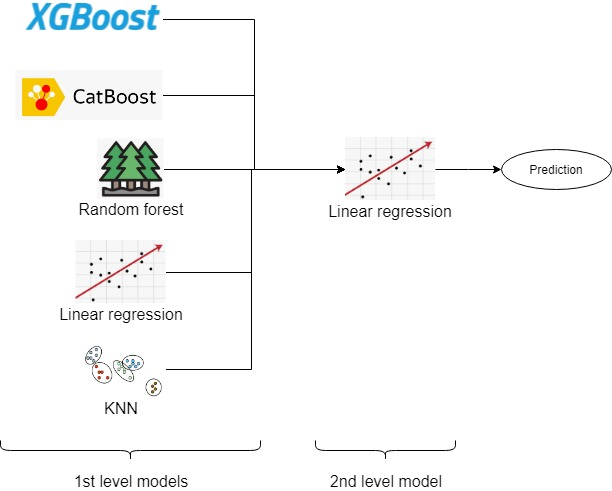

In [35]:
meta_model = LinearRegression(n_jobs=-1)

Trained on validation set using the 1st level models predictions as features.

In [36]:
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Make predictions on test set using the 1st level models predictions as features.

In [37]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [41]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Train rmse: 0.7672505539406883


In [43]:
test = pd.read_csv('/content/drive/MyDrive/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32','item_id': 'int32'})

In [44]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('/content/drive/MyDrive/submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.782049
1,1,0.075049
2,2,1.401732
3,3,0.075049
4,4,0.075049
5,5,0.881121
6,6,1.169442
7,7,0.187786
8,8,1.995430
9,9,0.075049


kaggle score : 1.137